In [3]:
import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import pacf, acf
from statsmodels.tsa.arima.model import ARIMA

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
# from arch import arch_model
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as st

# Read functions

In [ ]:
def read_data(data_path : str = "data/bilan.csv") -> pd.DataFrame:
    df = pd.read_csv(data_path)
    df['horodate'] = pd.to_datetime(df['horodate']) # Convert 'horodate' column to datetime
    df = df.set_index('horodate') # Set 'horodate' as the index
    # Filter rows where the value of column "Mois" is 6
    df = df[df['Mois'] == 6]
    hourly_avg = df.groupby(pd.Grouper(freq='H'))['consommation_totale'].mean().reset_index(name='consommation_totale')
    return hourly_avg

In [15]:
import requests
import pandas as pd
import os
from google.colab import drive

drive.mount('/content/gdrive')
if os.getcwd() != "/content/gdrive/MyDrive/Colab Notebooks/EI_ST4_G1/EI_TS_CS-20230526T084435Z-001/EI_TS_CS":
  os.chdir("/content/gdrive/MyDrive/Colab Notebooks/EI_ST4_G1/EI_TS_CS-20230526T084435Z-001/EI_TS_CS")

URL = "https://data.enedis.fr/api/explore/v2.0/catalog/datasets/bilan-electrique-demi-heure/exports/json"

PARAMS = {
        "limit" : -1,
        "sort" : "horodate"
    }

DATA_PATH = "data/bilan.csv"
FEATURE = "consommation_totale"
columns = ["horodate", FEATURE]

if not(os.path.isfile(DATA_PATH)):
    req = requests.get(URL, PARAMS).json()
    df = pd.json_normalize(req)
    df.to_csv(DATA_PATH)
df_full = pd.read_csv(DATA_PATH)

df_full["horodate"] = pd.to_datetime(df_full["horodate"].astype(str).apply(lambda x: x[:19]), format='%Y-%m-%dT%H:%M:%S')
df = df_full[columns]

df["date"] = df["horodate"].dt.date
df_day = df.groupby("date")[FEATURE].mean().reset_index()

X = np.array([0]*1826)
Y = np.array([0]*1826)
for i in range(0,1826):
    X[i] = (df_day.loc[i,1])
    Y[i] = (df_day.loc[i,1])
print(df_day,X,Y)

# Calculer la corrélation entre x et y
correlation = np.corrcoef(df_day, df_day)[0, 1]

# Tracer le graphique de dispersion
plt.scatter(X, Y)

# Ajouter la ligne de corrélation
plt.plot([min(X), max(X)], [min(Y), max(Y)], color='red')

# Ajouter le coefficient de corrélation sur le graphique
plt.text(0.5, 9, f"Corrélation : {correlation:.2f}", fontsize=12)

# Ajouter des labels et un titre au graphique
plt.xlabel('Variable x')
plt.ylabel('Variable y')
plt.title('Corrélation entre deux variables')

# Afficher le graphique
plt.show()


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


<ipython-input-15-8e76470a2b25>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"] = df["horodate"].dt.date


KeyError: ignored

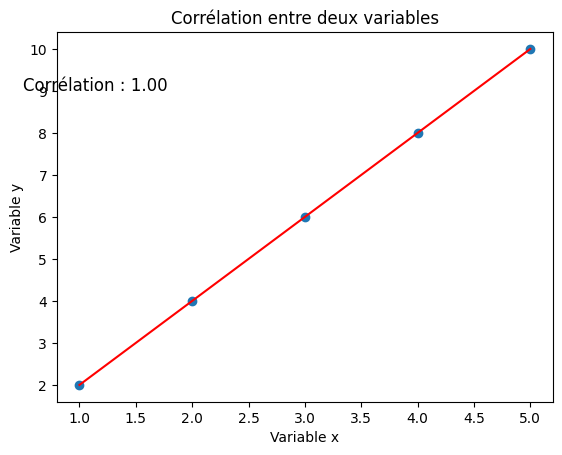

In [6]:

import matplotlib.pyplot as plt
import numpy as np

# Données d'exemple
x = np.array([1, 2, 3, 4, 5])
y = np.array([2, 4, 6, 8, 10])

# Calculer la corrélation entre x et y
correlation = np.corrcoef(x, y)[0, 1]

# Tracer le graphique de dispersion
plt.scatter(x, y)

# Ajouter la ligne de corrélation
plt.plot([min(x), max(x)], [min(y), max(y)], color='red')

# Ajouter le coefficient de corrélation sur le graphique
plt.text(0.5, 9, f"Corrélation : {correlation:.2f}", fontsize=12)

# Ajouter des labels et un titre au graphique
plt.xlabel('Variable x')
plt.ylabel('Variable y')
plt.title('Corrélation entre deux variables')

# Afficher le graphique
plt.show()

# Plot functions

In [ ]:
def create_corr_plot(series, plot_pacf=False):
    corr_array = pacf(series.dropna(), alpha=0.05) if plot_pacf else acf(series.dropna(), alpha=0.05)
    lower_y = corr_array[1][:,0] - corr_array[0]
    upper_y = corr_array[1][:,1] - corr_array[0]

    fig = go.Figure()
    [fig.add_scatter(x=(x,x), y=(0,corr_array[0][x]), mode='lines',line_color='#3f3f3f') 
     for x in range(len(corr_array[0]))]
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=corr_array[0], mode='markers', marker_color='#1f77b4',
                   marker_size=12)
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=upper_y, mode='lines', line_color='rgba(255,255,255,0)')
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=lower_y, mode='lines',fillcolor='rgba(32, 146, 230,0.3)',
            fill='tonexty', line_color='rgba(255,255,255,0)')
    fig.update_traces(showlegend=False)
    fig.update_xaxes(range=[-1,20])
    fig.update_yaxes(zerolinecolor='#000000')
    
    title='Partial Autocorrelation (PACF)' if plot_pacf else 'Autocorrelation (ACF)'
    fig.update_layout(title=title)
    fig.show()

In [ ]:
def plot_evolution_per_month(data):
    fig = go.Figure()
    color = ["#EBAFB9", "#C98F99", "#A76F79", "#865058", "#643038", "#421018"]
    quantity = data.iloc[:,START_TRAIN_INDEX:(END_TEST_INDEX+1)].sum().reset_index(name="Quantity").rename({"index" : "Date"}, axis=1)
    quantity["Date"] = pd.to_datetime(quantity["Date"])
    quantity["Year"] = quantity["Date"].dt.strftime('%Y')
    quantity["Month"] = quantity["Date"].dt.strftime('%B')
    for i, year in enumerate(range(2018, 2024)):
        fig.add_trace(go.Bar(
            x=quantity[quantity["Year"] == str(year)]["Month"],
            y=quantity[quantity["Year"] == str(year)]["Quantity"],
            name=year,
            marker_color=color[i]
        )
        )
    # Here we modify the tickangle of the xaxis, resulting in rotated labels.
    fig.update_layout(barmode='group', title = "Evolution per month")
    fig.update_xaxes(categoryorder='array', categoryarray= ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
    fig.show()